In [16]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the data directories
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir = 'dataset/val'

# Define data transformations for normalization
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Mean and std for normalization
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [17]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create the model instance
model = AlexNet(num_classes=4)


In [23]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    # Evaluate on validation set
    val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Finished Training")

# Evaluate on test set
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")


Epoch 1/30, Training Loss: 0.3302, Training Accuracy: 0.9472, Validation Accuracy: 0.8607
Epoch 2/30, Training Loss: 0.3085, Training Accuracy: 0.9174, Validation Accuracy: 0.8361
Epoch 3/30, Training Loss: 0.1586, Training Accuracy: 0.9541, Validation Accuracy: 0.8934
Epoch 4/30, Training Loss: 0.1500, Training Accuracy: 0.9771, Validation Accuracy: 0.8443
Epoch 5/30, Training Loss: 0.1050, Training Accuracy: 0.9702, Validation Accuracy: 0.8443
Epoch 6/30, Training Loss: 0.0940, Training Accuracy: 0.9748, Validation Accuracy: 0.8033
Epoch 7/30, Training Loss: 0.2304, Training Accuracy: 0.9587, Validation Accuracy: 0.8033
Epoch 8/30, Training Loss: 0.1288, Training Accuracy: 0.9702, Validation Accuracy: 0.8279
Epoch 9/30, Training Loss: 0.1168, Training Accuracy: 0.9656, Validation Accuracy: 0.8525
Epoch 10/30, Training Loss: 0.1021, Training Accuracy: 0.9725, Validation Accuracy: 0.8197
Epoch 11/30, Training Loss: 0.0764, Training Accuracy: 0.9885, Validation Accuracy: 0.8607
Epoch 12

Epoch 1/10, Training Loss: 0.4044, Training Accuracy: 0.9472, Validation Accuracy: 0.8361
Epoch 2/10, Training Loss: 0.1895, Training Accuracy: 0.9587, Validation Accuracy: 0.8279
Epoch 3/10, Training Loss: 0.0785, Training Accuracy: 0.9817, Validation Accuracy: 0.8361
Epoch 4/10, Training Loss: 0.0458, Training Accuracy: 0.9839, Validation Accuracy: 0.8115
Epoch 5/10, Training Loss: 0.0406, Training Accuracy: 0.9931, Validation Accuracy: 0.8197
Epoch 6/10, Training Loss: 0.1670, Training Accuracy: 0.9771, Validation Accuracy: 0.8033
Epoch 7/10, Training Loss: 0.5294, Training Accuracy: 0.9243, Validation Accuracy: 0.8033
Epoch 8/10, Training Loss: 0.2101, Training Accuracy: 0.9060, Validation Accuracy: 0.8361
Epoch 9/10, Training Loss: 0.0400, Training Accuracy: 0.9862, Validation Accuracy: 0.8197
Epoch 10/10, Training Loss: 0.0705, Training Accuracy: 0.9817, Validation Accuracy: 0.8197
Testing Loss: 1.3858, Testing Accuracy: 0.8516


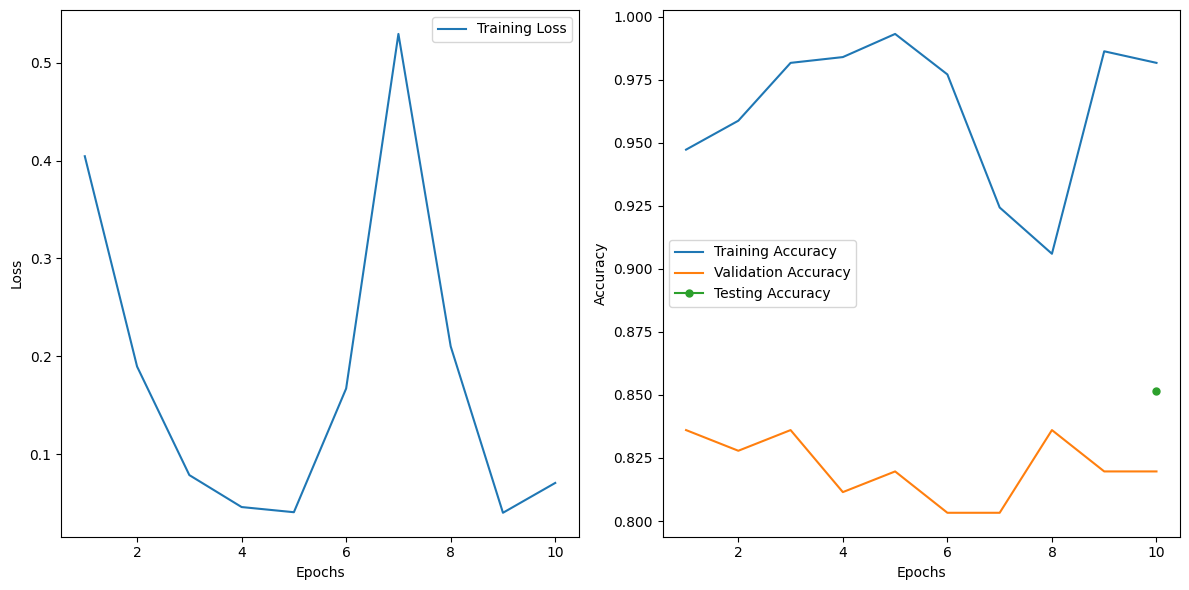

In [24]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    # Evaluate on validation set
    val_accuracy, val_precision, val_recall = evaluate_model(model, val_loader)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Append metrics to lists for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Evaluate on test set
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(len(epochs_range), test_accuracies, marker='o', markersize=5, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Testing Loss: 1.3858, Testing Accuracy: 0.8516


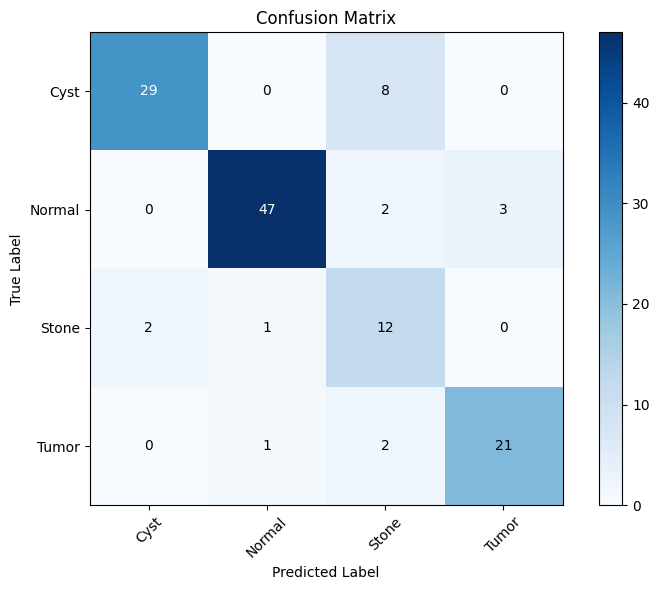

In [25]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# ... (previous code)

# Training loop and evaluation...
# ... (previous code)

# Evaluate on test set
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
all_predicted_labels = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        all_predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = correct_predictions / total_predictions

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
class_names = ["Cyst", "Normal", "Stone", "Tumor"]

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.0
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Lists to store training metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate training accuracy and loss for this epoch
    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    # Append training metrics to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Calculate validation accuracy and loss for this epoch
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    # Append validation metrics to the lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the progress for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/30, Training Loss: 2.3821, Training Accuracy: 25.00%, Validation Loss: 1.3976, Validation Accuracy: 18.03%
Epoch 2/30, Training Loss: 1.3446, Training Accuracy: 37.16%, Validation Loss: 1.4286, Validation Accuracy: 32.79%
Epoch 3/30, Training Loss: 1.3336, Training Accuracy: 32.11%, Validation Loss: 1.2996, Validation Accuracy: 50.82%
Epoch 4/30, Training Loss: 1.1832, Training Accuracy: 42.43%, Validation Loss: 1.0013, Validation Accuracy: 68.03%
Epoch 5/30, Training Loss: 1.0979, Training Accuracy: 50.69%, Validation Loss: 1.2485, Validation Accuracy: 39.34%
Epoch 6/30, Training Loss: 1.1346, Training Accuracy: 45.87%, Validation Loss: 1.1901, Validation Accuracy: 52.46%
Epoch 7/30, Training Loss: 1.0829, Training Accuracy: 49.54%, Validation Loss: 1.0799, Validation Accuracy: 45.90%
Epoch 8/30, Training Loss: 1.0462, Training Accuracy: 49.54%, Validation Loss: 1.0352, Validation Accuracy: 40.16%
Epoch 9/30, Training Loss: 0.9265, Training Accuracy: 60.55%, Validation Loss: 0

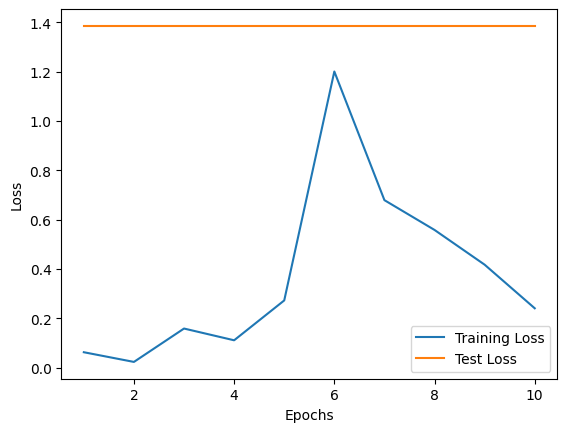

In [26]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# ... (previous code)

# Training loop
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ... (previous code)

    test_losses.append(test_loss)

# ... (previous code)

# Plotting Training Loss and Test Loss
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


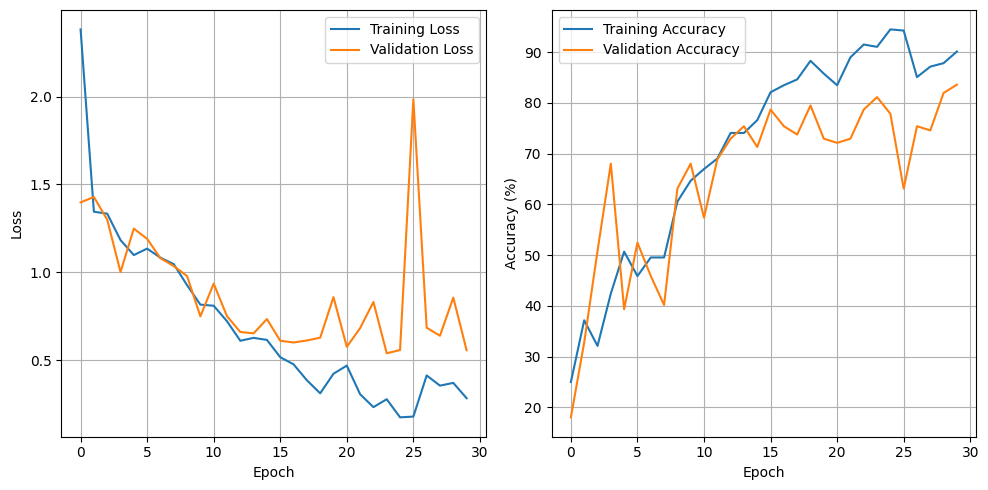

In [13]:

# Plot the metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

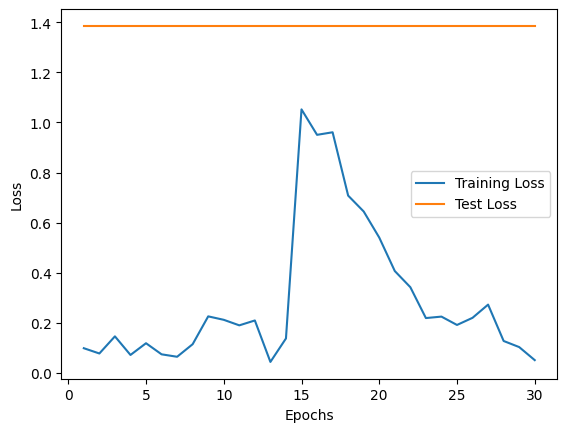

In [28]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# ... (previous code)

# Training loop
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ... (previous code)

    test_losses.append(test_loss)

# ... (previous code)

# Plotting Training Loss and Test Loss
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Validation Loss: 0.5564, Validation Accuracy: 83.61%


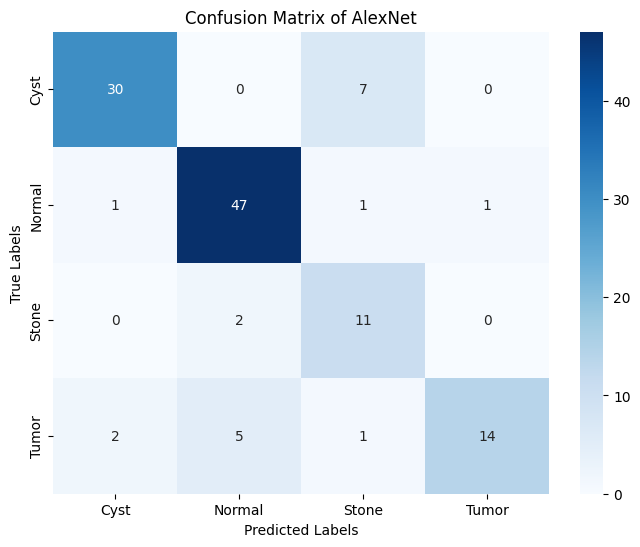

In [15]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Move the model to evaluation mode
model.eval()

val_loss = 0.0
correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

val_accuracy = 100 * correct / total
val_loss /= len(val_loader)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ["Cyst", "Normal", "Stone", "Tumor"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of AlexNet")
plt.show()